# Определение возраста покупателей

In [1]:
!pip install seaborn-qqplot

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm

from tqdm import tqdm

from PIL import Image, ImageChops

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

optimizer = Adam(lr=0.0001)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
def review(df): 
    """функция для отображения общей информации"""
    info = display(df.head(10)), df.info(), display(df.describe())
    if df.duplicated().sum() == 0:
        print('Дубликатов не обнаружено')
    else:
        print('Дубликатов найдено: {}'.format(df.duplicated().sum()))

In [3]:
df = pd.read_csv('/datasets/faces/labels.csv')

## Исследовательский анализ данных

Откроем файл и ознакомимся с данными

In [4]:
review(df)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Дубликатов не обнаружено


Проверим распределение на гистограме

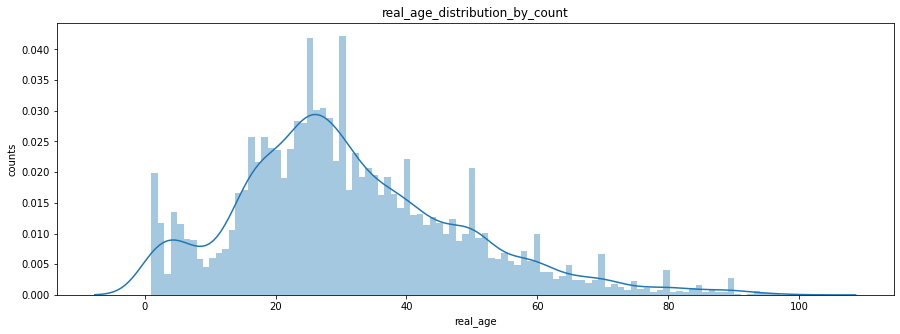

In [5]:
plt.figure(figsize=(15,5))
ax = sns.distplot(df['real_age'], bins=100)
plt.title('real_age_distribution_by_count')
plt.xlabel('real_age')
plt.ylabel('counts')
plt.show()

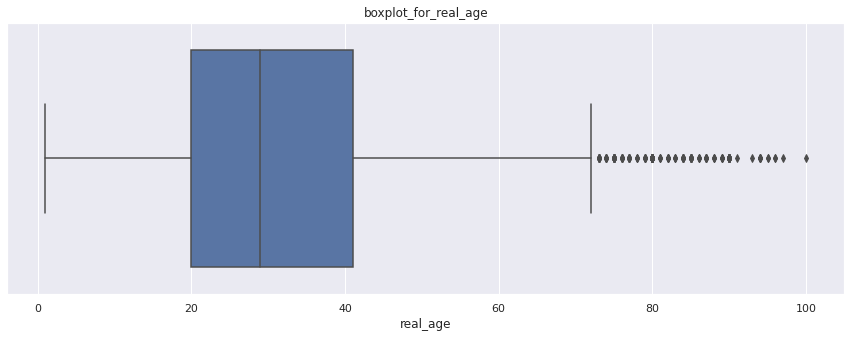

In [6]:
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
ax = sns.boxplot(x=df['real_age'])
plt.xlabel('real_age')
plt.title('boxplot_for_real_age')
plt.show()

Наблюдаются выбросы после `70` лет.

Проверим размеры изображений.

In [17]:
path = '/datasets/faces/final_files/'      
pictures = os.listdir(path)  
pictures = sorted(pictures)

In [31]:
width_size = []
height_size = []
for i, picture in tqdm(enumerate(pictures)):
    image = Image.open('/datasets/faces/final_files/' + picture)
    width = image.size[0] 
    height = image.size[1]
    width_size.append(str(width))
    height_size.append(str(height))
picsize = pd.DataFrame(data={'width':width_size, 'height':height_size})
picsize['size'] = picsize['width'] + 'x' + picsize['height']

7591it [00:44, 168.76it/s]


In [46]:
review(picsize)

,width,height,size
0,114,114,114x114
1,784,784,784x784
2,133,133,133x133
3,370,370,370x370
4,212,212,212x212
5,637,636,637x636
6,412,412,412x412
7,311,311,311x311
8,897,898,897x898
9,724,724,724x724


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   width   7591 non-null   object
 1   height  7591 non-null   object
 2   size    7591 non-null   object
dtypes: object(3)
memory usage: 178.0+ KB


,width,height,size
count,7591,7591,7591
unique,1195,1204,2293
top,165,165,517x517
freq,55,52,37


Дубликатов найдено: 5298


- изображения имеют разный размер;
- чаще всего изображения имеют размер `517х517`; 
- `2293` изображения имеют уникальный размер;
- `5298` изображений совпадают между собой по размерам.

Приведем изображения к размеру `224x224` и посмотрим на них.

In [83]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow  = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


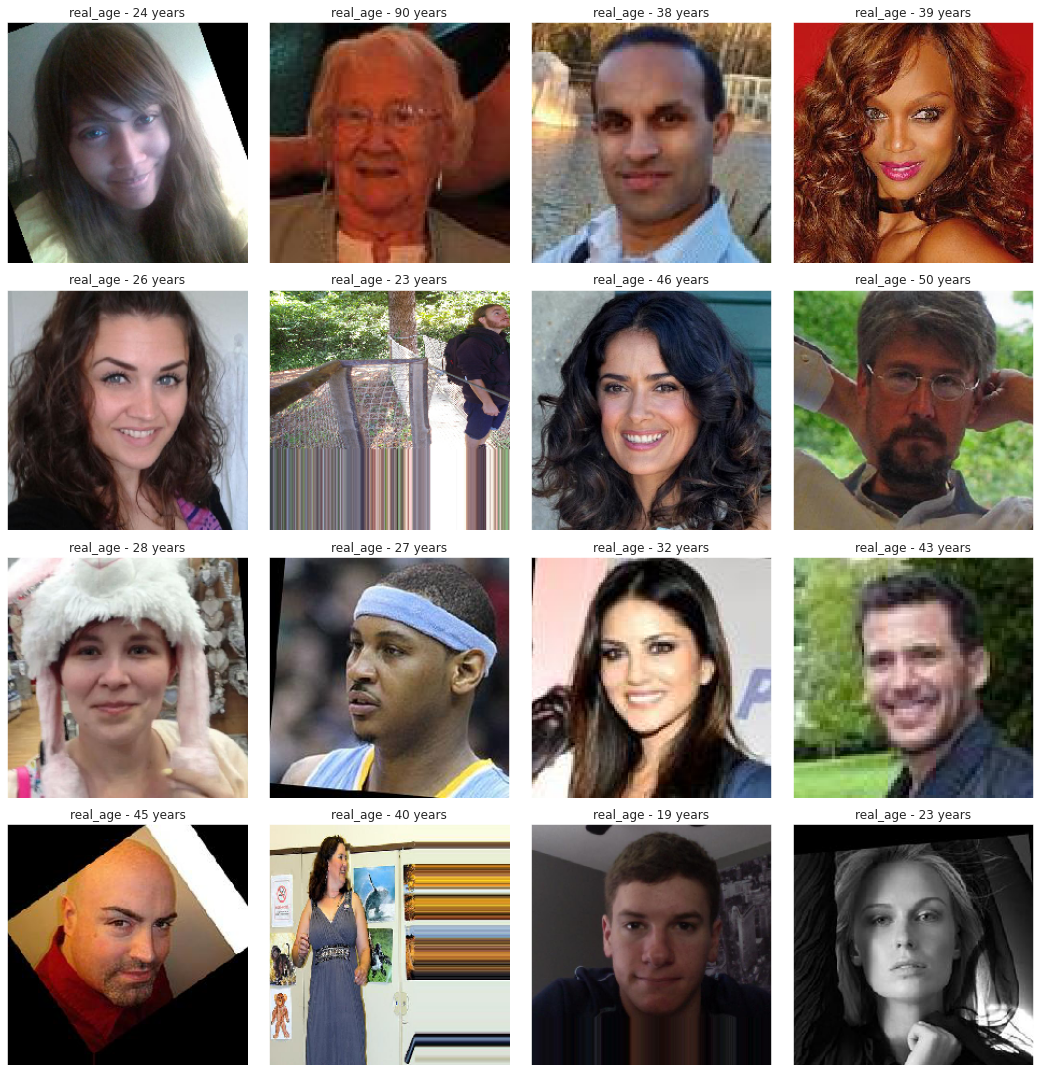

In [194]:
features, target = next(datagen_flow)

fig = plt.figure(figsize=(15,15))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('real_age - {} years'.format(target[i]))
    plt.tight_layout()

### Вывод

- данные содержат `7591` изображение;
- данные чистые, без явных дубликатов;
- данные распределены нормально со скошенностью вправо;
- наблюдаются выбросы после `70` лет;
- большинство данных собраны на людях с возрастом `30` лет;
- наблюдается бимодальность - после `30` лет наблюдаются пики с интервалом в 10 лет;
- изображения имеют разные размеры;
- фотографии имеют наклоны и тем самым на изображение создается черный фон за границей непосредственно фотографий;
- фотографии не центрированы, что также создает черный фон за границей непосредственно фотографий;
- фотографии зумированы, что также создает черный фон за границей непосредственно фотографий;
- фотографии имеют разную цветовую коррекцию, яркость, контрастность;
- фотографии сделаны в разных местах и имеют разную освещенность.

Следовательно:
- модель может некорректно определять возраст людей, которым более `30` лет;
- модель может некорректно определять возраст людей из-за разной освещенности, скошенности от центра, зума и наклона изображений.